
Goals:

* Understand the effect of regularization on generalization of deep neural network.
* Understand the design of multi-modal neural network, how to connect data from different sensory sources using deep network.


In [0]:
# Run this code block to load all the libraries
%tensorflow_version 2.x
%matplotlib inline
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from tensorflow import keras

sns.set()

TensorFlow 2.x selected.


# Question 1: Explicit regularization using Dropout

In `[0]`, the authors show that

> "Deep neural networks easily fit random labels",

and further provide:

1. The effective capacity of neural networks is sufficient for memorizing the entire data set.
2. Even optimization on random labels remains easy. In fact, training time increases only by a small constant factor compared with training on the true labels.
3. Replace the true images by completely random pixels and observe that convolutional neural networks continue to fit the data with zero training error.

As a result, the paper suggests two set of regularization methods that might improve the generalization of deep network:

* **Explicit regularization**: includes weight decay `[6]`, dropout (`[2]`, `[3]`), and data augmentation `[6]`. These techniques _may improve generalization performance, but is neither necessary nor by itself sufficient for controlling generalization error_. We will try to elaborate this issue in Question 1
* **Implicit regularization**: includes early stopping `[5]`, batch normalization `[4]`. These techniques interact with _SGD_ to influence the outcome during learning process, hence, _potentially_ improve the generalization. (Question 2)




Train size: 179
Valid size: 180
Test  size: 1438


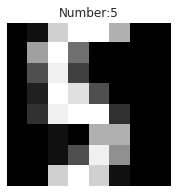

In [0]:
#@title Run the following block for loading the data, notice the **extreme** small amount of training data
X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,
                                                      y_train,
                                                      test_size=0.5)
print("Train size:", X_train.shape[0])
print("Valid size:", X_valid.shape[0])
print("Test  size:", X_test.shape[0])

plt.figure(figsize=(3, 3))
plt.imshow(X_train[8].reshape(8, 8), cmap='gray')
plt.axis('off')
_ = plt.title("Number:" + str(y_train[8]))

## **a)** Dropout as data augmentation

The procedure of applying dropout is summarized as follow:

$ h = W \cdot X + b, $

$ m \sim Bernoulli(1 - p), $

$ y = m \times f(h), $

where:

* $W$: weight matrix
* $X$: input matrix
* $b$: bias vector
* $p$: scalar value $(0, 1)$, the dropout rate
* $Bernoulli(\cdot)$: is sampling from Bernoullil distribution with the given success rate.
* $f(\cdot)$: is the activation function

Use this procedure to finish the implementaiton of `Dropout` layer. 

Then achieve > 90% accuracy on test set by adding `Dropout` to the neural network.

**NOTE**: it is common practice to reduce the dropout rate as the network getting deeper, since deep layers represent higher level of abstraction and is more sensitive to noise.

In [0]:
class Dropout(keras.layers.Layer):

  def __init__(self, p):
    # p: probability of dropping out a value
    super().__init__()
    assert 0 < p < 1
    self.p = p

  def call(self, inputs, training=None):
    if not training:
      return inputs

    mask = tf.random.uniform(shape=tf.shape(inputs), dtype=inputs.dtype)
    mask = tf.cast(mask >= self.p, dtype=inputs.dtype)
    outputs = inputs * mask
    outputs = outputs / (1 - self.p)
    return outputs

[Test] loss:0.77 acc:0.75


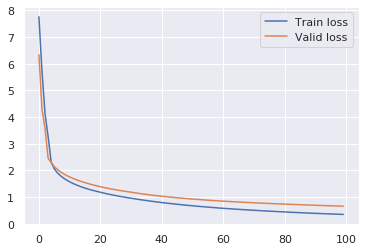

In [0]:
# SOLUTION: add dropout to this network to improve the test accuracy to 90%
model = keras.Sequential([
    # Dropout(0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)
model.fit(X_train,
          y_train,
          validation_data=(X_valid, y_valid),
          epochs=100,
          batch_size=256,
          verbose=False)
print("[Test] loss:%.2f acc:%.2f" %
      tuple(model.evaluate(X_test, y_test, verbose=False)))
# just show the learning curve here
history = model.history.history
plt.figure()
plt.plot(history['loss'], label='Train loss')
plt.plot(history['val_loss'], label='Valid loss')
_ = plt.legend()

## **b)** `DropConnect` - the network of networks.

The following code block implements `DropConnect` algorithm `[3]` for fully-connected network (a.k.a `Dense` layer).

Answer the following question:

* Writing down the procedure of the `DropConnect` algorithm in the same manner as `Dropout` in **a)**
* Add `DropConnect` to the network below to achieve > 90% accuracy on test set.
* Compare `DropConnect` to `Dropout` which algorithm is better? What are the differences between them?

---
The `DropConnect` algorithm:



$ m \sim Bernoulli(1 - p), $

$ W_{drop} = W \times m, $

$ h = W_{drop} \cdot X + b, $

$ y = f(h). $

`DropConnect` can be seen as generalized version of `Dropout`.
In `Dropout`, only the network activations are dropped, hence, it only affect the incoming input of the next layer.

`DropConnect` randomly remove the weights (i.e. the connection) from one layer to the next layer, as a result, affects both the outcome of previous layer and the income of the next layer.

`Dropout` augments the data, while `DropConnect` augments the network architecture. Training a `DropConnect` network is like ensemble infinite set of different network architecture.

In [0]:
class DropConnectDense(keras.layers.Layer):

  def __init__(self, units, activation=None, p=0.3, **kwargs):
    super().__init__(**kwargs)
    self.units = int(units)
    self.activation = keras.activations.get(activation)
    assert 0 < p < 1
    self.p = p

  def build(self, input_shape):
    last_dim = input_shape[-1]
    self.kernel = self.add_weight('kernel',
                                  shape=[last_dim, self.units],
                                  initializer='glorot_uniform',
                                  dtype=self.dtype,
                                  trainable=True)
    self.bias = self.add_weight('bias',
                                shape=(self.units,),
                                initializer='zeros',
                                dtype=self.dtype,
                                trainable=True)
    return super().build(input_shape)

  def call(self, inputs, training=None):
    kernel = self.kernel
    bias = self.bias
    if training:
      m = tf.random.uniform(shape=tf.shape(kernel), dtype=kernel.dtype)
      m = tf.cast(m > self.p, dtype=kernel.dtype)
      kernel = (kernel * m) / (1 - self.p)
    return self.activation(inputs @ kernel + bias)

[Test] loss:0.32 acc:0.91


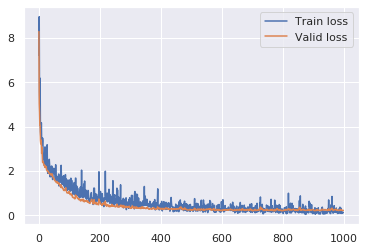

In [0]:
# SOLUTION: add DropConnect to this network to improve the test accuracy to 90%
model = keras.Sequential([
    DropConnectDense(32, activation='relu'),
    keras.layers.Dense(32, activation='relu'),    
    keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)
model.fit(X_train,
          y_train,
          validation_data=(X_valid, y_valid),
          epochs=1000,
          batch_size=256,
          verbose=False)
print("[Test] loss:%.2f acc:%.2f" %
      tuple(model.evaluate(X_test, y_test, verbose=False)))
# just show the learning curve here
history = model.history.history
plt.figure()
plt.plot(history['loss'], label='Train loss')
plt.plot(history['val_loss'], label='Valid loss')
_ = plt.legend()

# Question 2: Implicit regularization

According to `[4]`, training deep Networks is complicated by the fact
that: 

1. The distribution of each layer’s inputs changes during
training, as the parameters of the previous layers change.
2. This slows down the training by requiring lower learning
rates and careful parameter initialization, and makes it notoriously hard to train models with saturating nonlinearities.

This phenomenon as `internal covariate shift`, imagine _"solving hanoi tower problem on an unicycle"_.

They propose batch normalization algorithm for tackling the issue:
![alt text](https://drive.google.com/uc?export=view&id=1_6R1kXCPBSYJ43u8kojIOIvXsab-mR-v)


## **a)** Filling in the **TODO** of the following code block, add batch normalization and fix early stopping algorithm to achieve at least 92% accuracy on test set

Detail of batch normalization layer could be found here: https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization

and early stopping callback: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

[Train] loss:0.11 acc:1.00
[Valid] loss:0.35 acc:0.92
[Test] loss:0.40 acc:0.92


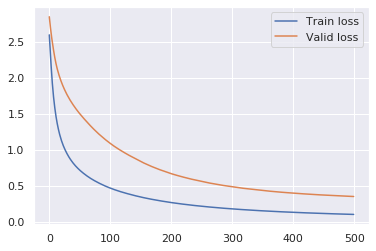

In [0]:
# Fix the random seed so the same initialization every run
np.random.seed(8)
tf.random.set_seed(8)

# SOLUTION: add batch normalization to this model to achieve at least 92% accuracy
model = keras.Sequential([
    # keras.layers.Dropout(0.3),
    keras.layers.Reshape(target_shape=(8, 8, 1)),
    keras.layers.Conv2D(16, 3, activation='linear', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Conv2D(32, 5, strides=2, activation='linear', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)
model.fit(X_train,
          y_train,
          validation_data=(X_valid, y_valid),
          epochs=500,
          batch_size=256,
          # TODO: The early stop algorithm here is broken, fix it!
          callbacks=[keras.callbacks.EarlyStopping()],
          verbose=False)

print("[Train] loss:%.2f acc:%.2f" %
      tuple(model.evaluate(X_train, y_train, verbose=False)))
print("[Valid] loss:%.2f acc:%.2f" %
      tuple(model.evaluate(X_valid, y_valid, verbose=False)))
print("[Test] loss:%.2f acc:%.2f" %
      tuple(model.evaluate(X_test, y_test, verbose=False)))

history = model.history.history
plt.figure()
plt.plot(history['loss'], label='Train loss')
plt.plot(history['val_loss'], label='Valid loss')
_ = plt.legend()

## **b)** Can you use `Dropout` together with `BatchNormalization` to achieve better performance?

According to `[4]`, it is recommended to remove `Dropout`. Batch Normalization fulfills some of the same goals as Dropout (i.e. it speeds up training, without increasing overfitting).

When training with Batch Normalization, a training example is seen in conjunction with other examples in the mini-batch, and the training network no longer producing deterministic values for a given training example.

However, [a theorical analysis is needed to justify this disharmony](https://arxiv.org/pdf/1801.05134.pdf). When Dropout layers are applied before Batch Normalization, “variance shift” phenomenon happens. Because dropout behave differently during test time, this lead to improper neural variance and shift, as a result, an unexpected prediction.

Recent experiments suggest benefit from applying an [independent components block](https://arxiv.org/pdf/1905.05928.pdf) (i.e. BN => Dropout) to provide better uncorrelated features, and lead to better performance in residual network

# Question 3: Multi-modal deep learning

Create a **multi-modal** calculator using the trained neural network: 

* Given an image of hand-written digits
* and an audio segment of spoken digits

The program should output the sum of the numbers represented in both the image and the audio file. 

Test the program with few different combinations of image and audio

In [0]:
#@title Run this block for all the functions that preprocessing the data
# ====== load MNIST ====== #
def deprocess(img):
  r""" [-1, 1] -> [0,255] """
  img = 255 * (img + 1.0) / 2.0
  return tf.cast(img, tf.uint8)


def process_image(data):
  r""" [0,255] -> [-1, 1]"""
  img = data['image']
  lab = data['label']
  img = (tf.cast(img, tf.float32) / 255.0 - 0.5) * 2.0
  return img, tf.cast(lab, tf.float32)


# ====== FSDD ====== #
def load_fsdd():
  import zipfile
  url = 'https://github.com/Jakobovski/free-spoken-digit-dataset/archive/v1.0.8.zip'
  path = keras.utils.get_file('fsdd.zip', url)
  outpath = os.path.join(os.path.dirname(path), 'fsdd')
  if not os.path.exists(outpath):
    with zipfile.ZipFile(path, 'r') as zf:
      zf.extractall(outpath)
  outpath = os.path.join(outpath, 'free-spoken-digit-dataset-1.0.8/recordings')
  all_files = [os.path.join(outpath, f) for f in os.listdir(outpath)]
  np.random.shuffle(all_files)
  return all_files


mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=40,
    num_spectrogram_bins=257,
    sample_rate=8000,
    lower_edge_hertz=125.0,
    upper_edge_hertz=3800.0)


def wav2spec(path, mel_scale=True):
  name = tf.strings.split(tf.strings.split(path, '/')[-1], '_')
  digit = tf.strings.to_number(name[0], tf.float32)
  speaker = name[1]
  f = tf.io.read_file(path)
  y, sr = tf.audio.decode_wav(f)
  y = y[:, 0]  # only first channel
  sr = tf.cast(sr, tf.float32)
  s = tf.signal.stft(y,
                     frame_length=tf.cast(0.025 * sr, tf.int32),
                     frame_step=tf.cast(0.005 * sr, tf.int32),
                     fft_length=512)
  if mel_scale:
    spec = tf.tensordot(tf.abs(s), mel_weight_matrix, 1)
  else:
    spec = tf.pow(tf.abs(s), 2)
  spec = tf.math.log(spec + 1e-6)
  return y, spec, digit, speaker


# ====== plot spectrogram ====== #
def create_calculator(img_dataset,
                      audio_filelist,
                      batch_size=64,
                      max_length=200,
                      training=None):
  from collections import defaultdict
  audio_filelist = list(audio_filelist)
  np.random.shuffle(audio_filelist)
  n_audio = len(audio_filelist)
  audio = tf.convert_to_tensor(audio_filelist)

  def process(data):
    img, digit1 = process_image(data)
    path = audio[tf.cast(tf.random.uniform(shape=()) * n_audio, tf.int64)]
    y, spec, digit2, speaker = wav2spec(path)
    spec = spec[:max_length]
    return img, spec, tf.cast(digit1, tf.float32) + tf.cast(digit2, tf.float32)

  if training:
    ds = img_dataset.shuffle(10000)
  else:
    ds = img_dataset
  ds = ds.map(process).cache()
  structure = tf.data.experimental.get_structure(ds)
  n_features = structure[1].shape[1]
  ds = ds.padded_batch(batch_size,
                       padded_shapes=(structure[0].shape,
                                      [max_length, n_features], []))
  ds = ds.map(lambda x, y, z: ((x, y), z)).prefetch(
      tf.data.experimental.AUTOTUNE)
  return ds

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/1.0.0. Subsequent calls will reuse this data.
7241728/Unknown - 2s 0us/stepImage shape: (28, 28, 1)
Audio shape: (200, 40)


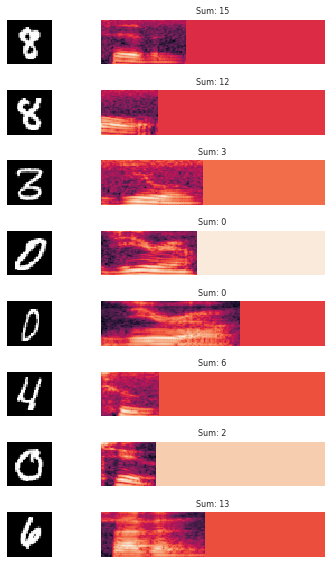

In [0]:
# This block will create train and test data
mnist = tfds.load('mnist')
fsdd = load_fsdd()
train_files = fsdd[:int(0.8 * len(fsdd))]
test_files = fsdd[int(0.8 * len(fsdd)):]

train = create_calculator(mnist['train'], train_files, training=True)
test = create_calculator(mnist['test'], test_files, training=False)
struture = tf.data.experimental.get_structure(train)
image_shape = struture[0][0].shape[1:]
audio_shape = struture[0][1].shape[1:]
print("Image shape:", image_shape)
print("Audio shape:", audio_shape)

# plot couple of examples
for (img, spec), y in create_calculator(mnist['train'], train_files):
  break
plt.figure(figsize=(6, 8))
for idx in range(8):
  i = img[idx].numpy()
  s = spec[idx].numpy()
  j = y[idx]
  plt.subplot(8, 2, idx * 2 + 1)
  plt.imshow(i[:, :, 0], cmap='gray')
  plt.axis('off')
  ax = plt.subplot(8, 2, idx * 2 + 2)
  ax.pcolorfast(s.T)
  plt.title('Sum: %d' % j, fontsize=8)
  plt.axis('off')
plt.tight_layout()

Finish the implementation of `MultiModalArithmetic` and achieve at least 90% accuracy of the summation between image and audio file.

Refer to `[7, 8, 9]` for design such system. Our a goal is, step-by-step:

* Create an unified representation of by combining specific representation of image and audio
* Use this representation to train a network that recognize the summation of the digit.

The follow figure is a good starting point:
![alt text](https://drive.google.com/uc?export=view&id=1BCk916Qo-Qy7U8P-y1kgGVVteaEQ93Ra)

In [0]:
class MultiModalArithmetic(keras.Model):

  def __init__(self, image_shape, audio_shape):
    super().__init__()
    self.model_image = keras.Sequential([
        keras.layers.Conv2D(16, 3, activation='relu', input_shape=image_shape),
        keras.layers.MaxPool2D(2),
        keras.layers.Conv2D(32, 3, activation='relu'),
        keras.layers.MaxPool2D(2),
        keras.layers.Conv2D(64, 3, activation='relu'),
        keras.layers.MaxPool2D(2),
        keras.layers.Flatten(),
    ],
                                        name="ImageNet")
    self.model_audio = keras.Sequential([
        keras.layers.Conv1D(32, 3, activation='relu', input_shape=audio_shape),
        keras.layers.Conv1D(64, 5, strides=2, activation='relu'),
        keras.layers.Conv1D(64, 5, strides=2, activation='relu'),
        keras.layers.Conv1D(64, 5, strides=2, activation='relu'),
        keras.layers.AvgPool1D(2),
        keras.layers.Flatten(),
    ],
                                        name="AudioNet")
    self.model_sum = keras.Sequential([
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(19, activation='softmax'),
    ],
                                      name="Sumnet")

  def call(self, inputs, training=None):
    image, audio = inputs
    image_feats = self.model_image(image, training=training)
    audio_feats = self.model_audio(audio, training=training)

    features = tf.concat([image_feats, audio_feats], axis=1)
    return self.model_sum(features, training=training)

In [0]:
model = MultiModalArithmetic(image_shape, audio_shape)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train.repeat(20))
model.evaluate(test)

18760/18760 [==============================] - 421s 22ms/step - loss: 0.0894 - accuracy: 0.9707
    157/Unknown - 43s 271ms/step - loss: 0.3824 - accuracy: 0.9462

[0.3823634216822921, 0.9462]

In [0]:
# Another design with much less parameters, using shared network for both visual and audio
class SharedConvArithmetic(keras.Model):

  def __init__(self, image_shape, audio_shape):
    super().__init__()
    self.model_share = keras.Sequential([
        keras.layers.Conv2D(16, 3, activation='relu'),
        keras.layers.MaxPool2D(2),
        keras.layers.Conv2D(32, 3, activation='relu'),
        keras.layers.MaxPool2D(2),
        keras.layers.Conv2D(64, 3, activation='relu'),
        keras.layers.MaxPool2D(2),
        keras.layers.Flatten(),
    ],
                                        name="AudioVisualNet")
    self.model_sum = keras.Sequential([
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(19, activation='softmax'),
    ],
                                      name="Sumnet")

  def call(self, inputs):
    image, audio = inputs
    # convert audio signal to 2D image with only 1 channel
    audio = tf.expand_dims(audio, axis=-1)
    image_feats = self.model_share(image)
    audio_feats = self.model_share(audio)
    features = tf.concat([image_feats, audio_feats], axis=1)
    return self.model_sum(features)